In [ ]:
!pip install kagglehub torchmetrics
!pip install albumentations

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 963.5/963.5 kB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 38.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 33.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 104.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

# 1-DEEP PART

## 1.1-IMPORTS

In [ ]:
import os
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image, ImageEnhance
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import pandas as pd
import random

from torchmetrics.detection import MeanAveragePrecision
import kagglehub

import os
import sys
from datetime import datetime
from sklearn.model_selection import train_test_split

from torchvision.models.detection import (
    fasterrcnn_resnet50_fpn,
    fasterrcnn_mobilenet_v3_large_fpn,
    FasterRCNN,
    retinanet_resnet50_fpn,
    RetinaNet
)
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models import resnet101
from torchvision.models._utils import IntermediateLayerGetter
from torchvision.models.detection.backbone_utils import BackboneWithFPN
from torchvision.models import resnext101_32x8d
from torchvision.models.detection.rpn import AnchorGenerator

torch.cuda.empty_cache()


## 1.2-RANDOM SEED

In [ ]:
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## 1.3-CONFIG

In [ ]:
# ==== CONFIG ====
class Config:
    path = kagglehub.dataset_download("orvile/p-vivax-malaria-infected-human-blood-smears")
    BASE_DIR = path + "/malaria/"
    IMG_DIR = os.path.join(BASE_DIR, "images")
    TRAIN_JSON = os.path.join(BASE_DIR, "training.json")
    TEST_JSON = os.path.join(BASE_DIR, "test.json")

    NUM_CLASSES = 8  # 7 + background
    MODEL_SAVE_PATH = "malaria_detection.pth"

    BATCH_SIZE = 4 if torch.cuda.is_available() else 2
    NUM_EPOCHS = 5
    LEARNING_RATE = 0.0003
    WEIGHT_DECAY = 0.001
    PATIENCE = 5

    IMG_SIZE = (800, 800)

    MODEL = "FASTER_RCNN_MOBILENET" # FASTER_RCNN_RESNET50, FASTER_RCNN_RESNET101,
                                   # FASTER_RCNN_MOBILENET, RETINANET_RESNET50,
                                   # FASTER_RCNN_RESNEXT101, RETINANET_RESNEXT101
    CustomAnchor = True
    Loss = "FocalLoss" # Standard, FocalLosss

    Optim = "AdamW" # Adam, AdamW
    Scheduler = "ReduceLROnPlateau" # ReduceLROnPlateau, CosineAnnealingLR
    val_size = 0.2
    NUM_WORKERS = 2
    USE_AMP = torch.cuda.is_available()

100%|██████████| 2.10G/2.10G [00:28<00:00, 78.9MB/s]

Extracting files...


### 1.3.1-SETUP DEVICE AND CLASSIFICATION

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

CLASSES = [
    "red blood cell", "trophozoite", "ring", "difficult",
    "schizont", "gametocyte", "leukocyte"
]
CLASS_TO_IDX = {cls: i+1 for i, cls in enumerate(CLASSES)}

Using device: cuda


## 1.4-DATASET

In [ ]:
class MalariaDataset(Dataset):
    def __init__(self, json_path, img_dir, transform=None, resize=True):
        with open(json_path) as f:
            self.data = json.load(f)
        self.img_dir = img_dir
        self.transform = transform
        self.resize = resize

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        entry = self.data[idx]

        img_name = os.path.basename(entry['image'].get('pathname',
                          entry['image'].get('filename',
                          entry['image'].get('id', ''))))
        img_path = os.path.join(self.img_dir, img_name)

        # Load and amplify the contrast of the image
        img = Image.open(img_path).convert("RGB")
        img = ImageEnhance.Contrast(img).enhance(1.5)
        orig_width, orig_height = img.size

        # Bounding box e label
        boxes, labels = [], []

        for obj in entry.get('objects', []):
            if obj['category'] not in CLASS_TO_IDX:
                continue
            bbox = obj['bounding_box']
            xmin = bbox['minimum']['c']
            ymin = bbox['minimum']['r']
            xmax = bbox['maximum']['c']
            ymax = bbox['maximum']['r']
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(CLASS_TO_IDX[obj['category']])

        boxes = np.array(boxes)
        labels = np.array(labels)

        # Convert PIL in Numpy for Albumentations
        img_np = np.array(img)


        if self.resize and self.transform is None:
            scale_x = Config.IMG_SIZE[0] / orig_width
            scale_y = Config.IMG_SIZE[1] / orig_height
            img_np = np.array(img.resize(Config.IMG_SIZE))
            boxes = [[xmin * scale_x, ymin * scale_y, xmax * scale_x, ymax * scale_y]
                     for xmin, ymin, xmax, ymax in boxes]

        # Apply Transforms
        if self.transform:
            transformed = self.transform(image=img_np, bboxes=boxes, labels=labels)
            img_tensor = transformed['image']
            boxes = torch.tensor(transformed['bboxes'], dtype=torch.float32)
            labels = torch.tensor(transformed['labels'], dtype=torch.int64)
        else:
            # fallback if there isn't Albumentations
            img_tensor = transforms.ToTensor()(img)
            img_tensor = transforms.Normalize(mean=[0.7205, 0.7203, 0.7649],
                                              std=[0.2195, 0.2277, 0.1588])(img_tensor)
            boxes = torch.tensor(boxes, dtype=torch.float32)
            labels = torch.tensor(labels, dtype=torch.int64)

        target = {"boxes": boxes, "labels": labels}
        return img_tensor, target


### 1.4.1-Extract Boxes Distribution

In [ ]:
# import torch
# from torch.utils.data import DataLoader
# import matplotlib.pyplot as plt
# import numpy as np
# from sklearn.cluster import KMeans
# from tqdm import tqdm

# # Load the Dataset
# dataset = MalariaDataset(Config.TRAIN_JSON, Config.IMG_DIR,
#                                   transform=None)

# # Extract W&H
# widths = []
# heights = []

# for i in tqdm(range(len(dataset))):
#     _, target = dataset[i]
#     boxes = target['boxes']
#     for box in boxes:
#         xmin, ymin, xmax, ymax = box.tolist()
#         w = xmax - xmin
#         h = ymax - ymin
#         if w > 0 and h > 0:
#             widths.append(w)
#             heights.append(h)

# # Convert into array for Kmeans
# sizes = np.array(list(zip(widths, heights)))

# # Plotting
# plt.figure(figsize=(8, 6))
# plt.scatter(widths, heights, alpha=0.3)
# plt.xlabel("Width")
# plt.ylabel("Height")
# plt.title("Distribuzione delle dimensioni delle bounding box")
# plt.grid(True)
# plt.show()

# # K-means for anchors
# n_anchors = 6
# kmeans = KMeans(n_clusters=n_anchors, random_state=0).fit(sizes)
# anchors = kmeans.cluster_centers_

# print(f"Ancore suggerite (w, h):\n{anchors}")


## 1.5-TRANSFORMATION

In [ ]:
# import os
# from PIL import Image
# import numpy as np
# from tqdm import tqdm
# import torch

# from torchvision import transforms

# # === CONFIG ===
# IMG_DIR = Config.IMG_DIR

# # === Trasformazione base ===
# to_tensor = transforms.ToTensor()  # converte a [C, H, W] in [0, 1]

# # === Liste per accumulare pixel per canale ===
# mean = torch.zeros(3)
# std = torch.zeros(3)
# n_images = 0

# print("Inizio calcolo media/std da immagini...")

# for fname in tqdm(os.listdir(IMG_DIR)):
#     if not fname.lower().endswith((".png", ".jpg", ".jpeg")):
#         continue  # ignora file non immagine

#     img_path = os.path.join(IMG_DIR, fname)
#     img = Image.open(img_path).convert("RGB")
#     tensor = to_tensor(img)  # shape: [3, H, W]

#     mean += tensor.mean(dim=(1, 2))
#     std += tensor.std(dim=(1, 2))
#     n_images += 1

# mean /= n_images
# std /= n_images

# print(f"\nMedia RGB: {mean}")
# print(f"Deviazione standard RGB: {std}")


In [ ]:
# ==== TRASFORMAZIONI ====
import albumentations as A
from albumentations.pytorch import ToTensorV2
def get_transforms(train=True):
    if train:
        return A.Compose([
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.3),
            A.RandomBrightnessContrast(p=0.3),
            A.MotionBlur(p=0.2),
            A.GaussNoise(p=0.2),
            A.CLAHE(p=0.2),
            A.CoarseDropout(
                num_holes_range=(3, 6),              # Random number of holes between 3 and 6
                hole_height_range=(10, 20),          # Hole height between 10 and 20 px
                hole_width_range=(10, 20),           # Hole width between 10 and 20 px
                fill="random_uniform",               # Fills holes with random uniform values
                p=0.2                                # Probability of applying this transform (20%)
            ),

            A.Resize(*Config.IMG_SIZE),
            A.Normalize(mean=[0.7205, 0.7203, 0.7649],
                        std=[0.2195, 0.2277, 0.1588]),
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

    else:
        return A.Compose([
            A.Resize(*Config.IMG_SIZE),
            A.Normalize(mean=[0.7205, 0.7203, 0.7649],
                        std=[0.2195, 0.2277, 0.1588]),
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

## 1.6-MODEL

### 1.6.1-Focal Loss

In [ ]:
# ==== FOCAL LOSS ====
import torch
import torch.nn.functional as F
from torchvision.models.detection.roi_heads import fastrcnn_loss as original_fastrcnn_loss

# Focal Loss
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=3.0, reduction='mean'):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        return focal_loss

# Custom fastrcnn_loss with focal loss
def custom_fastrcnn_loss(class_logits, box_regression, labels, regression_targets):
    # Focal loss for classification
    classification_loss = FocalLoss()(class_logits, labels)

    # Smooth L1 loss for bounding box regression (unchanged)
    sampled_pos_inds_subset = torch.where(labels > 0)[0]
    box_loss = F.smooth_l1_loss(
        box_regression[sampled_pos_inds_subset],
        regression_targets[sampled_pos_inds_subset],
        beta=1.0, reduction='sum'
    ) / max(1, labels.numel())

    return classification_loss, box_loss


In [ ]:
# ==== MODEL ====

# Focal loss patch (solo per Faster R-CNN)
def replace_fastrcnn_loss_with_focal(model):
    def custom_forward(self, class_logits, box_regression, labels, regression_targets):
        return custom_fastrcnn_loss(class_logits, box_regression, labels, regression_targets)
    model.roi_heads.fastrcnn_loss = custom_forward.__get__(model.roi_heads, type(model.roi_heads))


# Resnet101 with FPN
def build_resnet101_backbone():
    backbone = resnet101(weights="DEFAULT")
    return_layers = {
        'layer1': '0',
        'layer2': '1',
        'layer3': '2',
        'layer4': '3',
    }
    in_channels_stage2 = 256
    in_channels_list = [
        in_channels_stage2,
        in_channels_stage2 * 2,
        in_channels_stage2 * 4,
        in_channels_stage2 * 8,
    ]
    out_channels = 256

    body = IntermediateLayerGetter(backbone, return_layers=return_layers)
    backbone_with_fpn = BackboneWithFPN(
        body=body,
        return_layers=return_layers,
        in_channels_list=in_channels_list,
        out_channels=out_channels
    )
    return backbone_with_fpn

# ResNXet101 with FPN
def build_resnext101_backbone():
    backbone = resnext101_32x8d(weights="DEFAULT")

    # Layer Map
    return_layers = {
        'layer1': '0',
        'layer2': '1',
        'layer3': '2',
        'layer4': '3',
    }

    in_channels_stage2 = 256  # layer1 output
    in_channels_list = [
        in_channels_stage2,        # layer1
        in_channels_stage2 * 2,    # layer2
        in_channels_stage2 * 4,    # layer3
        in_channels_stage2 * 8,    # layer4
    ]
    out_channels = 256

    body = IntermediateLayerGetter(backbone, return_layers=return_layers)

    # Backbone for FPN
    backbone_with_fpn = BackboneWithFPN(
        body,
        return_layers=return_layers,
        in_channels_list=in_channels_list,
        out_channels=out_channels
    )
    return backbone_with_fpn


# Custom Anchors
anchor_generator = AnchorGenerator(
              sizes=((32,), (64,), (128,), (256,), (512,)),
              aspect_ratios=((0.5, 1.0, 2.0),) * 5
          )



def create_model(num_classes=2):
    if Config.MODEL == "FASTER_RCNN_RESNET50":
        model = fasterrcnn_resnet50_fpn(weights="DEFAULT")

    elif Config.MODEL == "FASTER_RCNN_RESNET101":
        backbone = build_resnet101_backbone()
        model = FasterRCNN(backbone=backbone, num_classes=num_classes)

    elif Config.MODEL == "FASTER_RCNN_MOBILENET":
        model = fasterrcnn_mobilenet_v3_large_fpn(weights="DEFAULT")

    elif Config.MODEL == "FASTER_RCNN_RESNEXT101":
        backbone = build_resnext101_backbone()
        if Config.CustomAnchor:
            model = FasterRCNN(
                backbone=backbone,
                rpn_anchor_generator=anchor_generator,
                num_classes=num_classes
            )
        else:
            model = FasterRCNN(backbone=backbone, num_classes=num_classes)

    elif Config.MODEL == "RETINANET_RESNET50":
        model = retinanet_resnet50_fpn(weights="DEFAULT")
        in_features = model.head.classification_head.cls_logits.in_channels
        num_anchors = model.head.classification_head.num_anchors
        model.head.classification_head.cls_logits = torch.nn.Conv2d(
            in_features, num_anchors * num_classes, kernel_size=3, stride=1, padding=1
        )
        model.head.classification_head.num_classes = num_classes

    elif Config.MODEL == "RETINANET_RESNEXT101":
        backbone = build_resnext101_backbone()
        anchor_generator_retina = AnchorGenerator(
            sizes=((32,), (64,), (128,), (256,), (512,)),
            aspect_ratios=((0.5, 1.0, 2.0),) * 5
        )

        model = RetinaNet(
            backbone=backbone,
            num_classes=num_classes,
            anchor_generator=anchor_generator_retina
        )

    else:
        raise ValueError(f"Backbone '{Config.MODEL}' non supportato.")

    # Only for Faster R-CNN: change classifier and enable focal loss
    if "FASTER_RCNN" in Config.MODEL:
        in_features = model.roi_heads.box_predictor.cls_score.in_features
        model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

        if Config.Loss == "FocalLoss":
            replace_fastrcnn_loss_with_focal(model)

    return model



## 1.6-TRAIN

In [ ]:
def train_model():
    model = create_model().to(device)
    # OPTIMIZER
    if Config.Optim == "AdamW":
      optimizer = torch.optim.AdamW(
          [p for p in model.parameters() if p.requires_grad],
          lr=Config.LEARNING_RATE, weight_decay=Config.WEIGHT_DECAY)
    elif Config.Optim == "Adam":
      optimizer = torch.optim.Adam(
          [p for p in model.parameters() if p.requires_grad],
          lr=Config.LEARNING_RATE, weight_decay=Config.WEIGHT_DECAY)
    # LR SCHEDULER
    if Config.Scheduler == "ReduceLROnPlateau":
      scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
          optimizer, mode='min', patience=2, factor=0.5)
    elif Config.Scheduler == "CosineAnnealingLR":
      scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
          optimizer, T_max=Config.NUM_EPOCHS, eta_min=1e-6)
    dataset = MalariaDataset(Config.TRAIN_JSON, Config.IMG_DIR,
                             transform=get_transforms(train=True), resize=False)

    # Split dataset into training and validation sets
    val_size = int(Config.val_size * len(dataset))
    train_size = len(dataset) - val_size
    train_dataset, val_dataset = torch.utils.data.random_split(
        dataset, [train_size, val_size],
        generator=torch.Generator().manual_seed(RANDOM_SEED)
    )

    # Create DataLoaders for both sets
    train_loader = DataLoader(train_dataset, batch_size=Config.BATCH_SIZE,
                              shuffle=True, num_workers=Config.NUM_WORKERS,
                              collate_fn=lambda x: tuple(zip(*x)))
    val_loader = DataLoader(val_dataset, batch_size=Config.BATCH_SIZE,
                            shuffle=False, num_workers=Config.NUM_WORKERS,
                            collate_fn=lambda x: tuple(zip(*x)))

    best_loss = float('inf')
    best_mAP = float('-inf')
    patience_counter = 0

    history = {
        'train_loss': [],
        'val_loss': [],
        'lr': []
    }

    for epoch in range(Config.NUM_EPOCHS):
        # --- Training phase ---
        model.train()
        epoch_train_loss = 0.0

        for images, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            for t in targets:
                t['labels'] = torch.ones_like(t['labels'])

            optimizer.zero_grad()

            with torch.amp.autocast('cuda', enabled=Config.USE_AMP):
                loss_dict = model(images, targets)
                losses = sum(loss for loss in loss_dict.values())

            losses.backward()
            optimizer.step()

            epoch_train_loss += losses.item()

        avg_train_loss = epoch_train_loss / len(train_loader)
        history['train_loss'].append(avg_train_loss)
        history['lr'].append(optimizer.param_groups[0]['lr'])

        # --- Validation phase ---
        print("\nStart Validation... 🔍")
        epoch_val_loss = 0.0

        # Force model.train() to get loss dict, but still disable gradients
        model.train()
        with torch.no_grad():
            for images, targets in val_loader:
                images = [img.to(device) for img in images]
                targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
                for t in targets:
                    t['labels'] = torch.ones_like(t['labels'])

                with torch.amp.autocast('cuda', enabled=Config.USE_AMP):
                    loss_dict = model(images, targets)

                    if isinstance(loss_dict, dict):
                        losses = sum(loss for loss in loss_dict.values())
                        epoch_val_loss += losses.item()
                    else:
                        raise ValueError("Model returned predictions instead of a loss dict during validation. Check model mode or target input.")

        avg_val_loss = epoch_val_loss / len(val_loader)
        history['val_loss'].append(avg_val_loss)

        scheduler.step(avg_val_loss)

        print(f"Epoch {epoch+1}/{Config.NUM_EPOCHS}")
        print(f"  Train Loss: {avg_train_loss:.4f}")
        print(f"  Val Loss: {avg_val_loss:.4f}")
        print(f"  LR: {optimizer.param_groups[0]['lr']:.2e}")

        map_res = compute_map(model, val_dataset, 0.5)

        # Best model in order to mAP50
        if map_res['map_50'] > best_mAP:
            best_mAP = map_res['map_50']
            torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'epoch': epoch,
                'best_mAP': best_mAP,
                'map': map_res['map_50']
            }, Config.MODEL_SAVE_PATH)
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= Config.PATIENCE:
                print(f"\nEarly stopping at epoch {epoch+1}")
                break

    return history


## 1.7-TEST AND VISUALIZZATION

### 1.7.1 - Extract ROI Features and Save in CSV File

In [ ]:
def extract_predicted_roi_features(model, dataset, save_path="roi_features_preds.csv", score_threshold=0.5, iou_threshold=0.5):
    model.eval()
    model.to(device)

    all_features = []
    all_metadata = []

    for i in tqdm(range(len(dataset)), desc="Extracting Predicted ROI Features"):
        img, target = dataset[i]
        img = img.to(device).unsqueeze(0)

        with torch.no_grad():
            outputs = model(img)

        if len(outputs[0]["boxes"]) == 0:
            continue

        pred_boxes = outputs[0]["boxes"].detach().cpu()
        scores = outputs[0]["scores"].detach().cpu()
        keep = scores > score_threshold

        pred_boxes = pred_boxes[keep]
        scores = scores[keep]

        gt_boxes = target["boxes"].cpu()
        gt_labels = target["labels"].cpu()

        if len(pred_boxes) == 0 or len(gt_boxes) == 0:
            continue

        # Match pred -> gt
        _, matches = compute_mean_iou_per_gt(pred_boxes, gt_boxes, iou_threshold)

        matched_pred_indices = [mp[0] for mp in matches]
        matched_gt_indices = [mp[1] for mp in matches]

        if not matches:
            continue

        with torch.no_grad():
            features = model.backbone(img)
            if not isinstance(features, dict):
                features = {"0": features}

            pred_boxes_tensor = pred_boxes[matched_pred_indices].to(device)

            box_features = model.roi_heads.box_roi_pool(
                features, [pred_boxes_tensor], [img.shape[-2:]]
            )
            box_features = model.roi_heads.box_head(box_features)

            # Extract
            cls_scores = model.roi_heads.box_predictor.cls_score(box_features)

        for feat, cls_score_vec, box, score, gt_idx in zip(
            box_features, cls_scores, pred_boxes_tensor, scores[matched_pred_indices], matched_gt_indices
        ):
            full_feat = torch.cat([feat, cls_score_vec], dim=0).detach().cpu().numpy()
            all_features.append(full_feat)

            # Add Metadata
            all_metadata.append({
                "image_id": i,
                "score": score.item(),
                "x1": box[0].item(),
                "y1": box[1].item(),
                "x2": box[2].item(),
                "y2": box[3].item(),
                "label": gt_labels[gt_idx].item()
            })


    # Convert into DataFrame
    df_meta = pd.DataFrame(all_metadata)
    feature_tensor = torch.tensor(all_features)
    feature_flat = feature_tensor.view(feature_tensor.size(0), -1).numpy()
    df_feat = pd.DataFrame(feature_flat)

    df = pd.concat([df_meta, df_feat], axis=1)
    df.to_csv(save_path, index=False)
    print(f"✅ ROI features predette salvate in: {save_path}")
    try:
        from google.colab import files
        files.download(save_path)
        print("⬇️ File pronto per il download!")
    except ImportError:
        print("⚠️ Non sei in Colab, download automatico non disponibile.")


### 1.7.2 - Evaluation

In [ ]:
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from sklearn.metrics import average_precision_score
import matplotlib.patches as patches
import json
from datetime import datetime

class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, (np.integer,)):
            return int(obj)
        elif isinstance(obj, (np.floating,)):
            return float(obj)
        elif isinstance(obj, (np.ndarray,)):
            return obj.tolist()
        return super().default(obj)

def calculate_iou(box1, box2):
    x1, y1 = max(box1[0], box2[0]), max(box1[1], box2[1])
    x2, y2 = min(box1[2], box2[2]), min(box1[3], box2[3])
    inter = max(0, x2 - x1) * max(0, y2 - y1)
    area1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
    area2 = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union = area1 + area2 - inter
    return inter / union if union > 0 else 0.0

def compute_mean_iou_per_gt(pred_boxes, gt_boxes, iou_threshold=0.5):
    if len(pred_boxes) == 0 or len(gt_boxes) == 0:
        return 0.0, []

    iou_matrix = [[calculate_iou(pb, gt) for gt in gt_boxes] for pb in pred_boxes]
    matched_pairs = []
    used_preds = set()

    for gt_idx in range(len(gt_boxes)):
        best_iou = 0.0
        best_pred_idx = -1
        for pred_idx in range(len(pred_boxes)):
            if pred_idx in used_preds:
                continue
            iou = iou_matrix[pred_idx][gt_idx]
            if iou > best_iou:
                best_iou = iou
                best_pred_idx = pred_idx
        if best_iou >= iou_threshold:
            matched_pairs.append((best_pred_idx, gt_idx, best_iou))
            used_preds.add(best_pred_idx)

    mean_iou = np.mean([iou for _, _, iou in matched_pairs]) if matched_pairs else 0.0
    return mean_iou, matched_pairs

def evaluate_test_set(model, dataset, score_threshold=0.5, save_path=None):
    model.eval()
    total_iou = 0.0
    num_samples = 0
    all_ious = []
    total_tp = total_fp = total_fn = 0

    for img, target in dataset:
        with torch.no_grad():
            prediction = model([img.to(device)])[0]

        pred_boxes = prediction['boxes'].cpu().numpy()
        pred_scores = prediction['scores'].cpu().numpy()
        gt_boxes = target['boxes'].cpu().numpy()

        keep = pred_scores >= score_threshold
        pred_boxes = pred_boxes[keep]

        mean_iou, matched_pairs = compute_mean_iou_per_gt(pred_boxes, gt_boxes)
        precision, recall, f1_score, tp, fp, fn = compute_precision_recall_f1(pred_boxes, gt_boxes)

        if len(gt_boxes) > 0:
            total_iou += mean_iou
            num_samples += 1
            all_ious.extend([iou for _, _, iou in matched_pairs])
            total_tp += tp
            total_fp += fp
            total_fn += fn

    mean_iou_all = total_iou / num_samples if num_samples > 0 else 0.0
    precision = total_tp / (total_tp + total_fp) if (total_tp + total_fp) > 0 else 0.0
    recall    = total_tp / (total_tp + total_fn) if (total_tp + total_fn) > 0 else 0.0
    f1_score  = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0

    results = {
        'miou': mean_iou_all,
        'precision': precision,
        'recall': recall,
        'f1': f1_score,
        'tp': total_tp,
        'fp': total_fp,
        'fn': total_fn
    }

    print(f"\n=== [Test Set Evaluation] ===")
    print(f"📊 Metriche globali:")
    print(f"  - mIoU     : {results['miou']:.4f}")
    print(f"  - Precision: {results['precision']:.4f}")
    print(f"  - Recall   : {results['recall']:.4f}")
    print(f"  - F1 Score : {results['f1']:.4f}")

    print(f"\n🔢 Conteggi:")
    print(f"  - TP: {results['tp']} | FP: {results['fp']} | FN: {results['fn']}")

    if all_ious:
        print(f"\n📈 IoU stats:")
        print(f"  - min   : {min(all_ious):.2f}")
        print(f"  - max   : {max(all_ious):.2f}")
        print(f"  - median: {np.median(all_ious):.2f}")
    else:
        print("\n📉 Nessun IoU calcolabile.")


    if save_path:
        with open(save_path, 'w') as f:
            json.dump(results, f, indent=2, cls=NpEncoder)
        print(f"Results saved to {save_path}")

    return results



def compute_precision_recall_f1(pred_boxes, gt_boxes, iou_threshold=0.5):
    """
    Calcola TP, FP, FN, Precision, Recall, F1 Score per una singola immagine.
    """
    matched_gt = set()
    tp = 0

    for pb in pred_boxes:
        match_found = False
        for i, gb in enumerate(gt_boxes):
            if i in matched_gt:
                continue
            iou = calculate_iou(pb, gb)
            if iou >= iou_threshold:
                tp += 1
                matched_gt.add(i)
                match_found = True
                break
    fp = len(pred_boxes) - tp
    fn = len(gt_boxes) - tp

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall    = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    f1_score  = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0

    return precision, recall, f1_score, tp, fp, fn


def compute_map(model, dataset, score_threshold=0.5, save_path=None):
    model.eval()
    metric = MeanAveragePrecision(iou_type="bbox")
    preds, targets = [], []

    for img, target in dataset:
        with torch.no_grad():
            pred = model([img.to(device)])[0]

        scores = pred['scores'].cpu()
        boxes = pred['boxes'].cpu()
        labels = pred['labels'].cpu()
        keep = scores >= score_threshold

        preds_dict = {
            "boxes": boxes[keep],
            "scores": scores[keep],
            "labels": torch.ones_like(labels[keep])
        }

        target_dict = {
            "boxes": target['boxes'].cpu(),
            "labels": torch.ones_like(target['labels'])
        }


        preds.append(preds_dict)
        targets.append(target_dict)

    metric.update(preds, targets)
    results = metric.compute()

    print(f"\n=== [mAP Evaluation] ===")
    for k, v in results.items():
        if torch.is_tensor(v):
            v = v.item() if v.numel() == 1 else v.tolist()
        if isinstance(v, float):
            print(f"  - {k}: {v:.4f}")
        else:
            print(f"  - {k}: {v}")

    if save_path:
        with open(save_path, 'w') as f:
            json.dump(results, f, indent=2, cls=NpEncoder)
        print(f"mAP results saved to {save_path}")

    return results


def save_results_to_file(test_results, map_results, out_path="results"):
    os.makedirs(out_path, exist_ok=True)
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    filepath = os.path.join(out_path, f"results_{timestamp}.json")

    def convert(o):
        if isinstance(o, torch.Tensor):
            return o.item() if o.numel() == 1 else o.tolist()
        elif isinstance(o, np.ndarray):
            return o.tolist()
        elif isinstance(o, (np.float32, np.float64)):
            return float(o)
        elif isinstance(o, (np.int32, np.int64)):
            return int(o)
        return str(o)

    config_dict = {
        key: convert(val) for key, val in vars(Config).items()
        if not key.startswith("__") and not callable(val)
    }

    transforms_obj = get_transforms(train=True)

    try:
        transforms_dict = transforms_obj.to_dict()
    except Exception as e:
        print(f"Warning: Could not serialize Albumentations transforms using to_dict(). Saving a placeholder. Error: {e}")
        transforms_dict = "Albumentations transforms could not be serialized using to_dict()."


    with open(os.path.join(out_path, "transformations.json"), 'w') as f:
        json.dump(transforms_dict, f, indent=4, default=convert)


    combined_results = {
        "config": config_dict,
        "transformations" : transforms_dict,
        "test_metrics": json.loads(json.dumps(test_results, default=convert)),
        "map_metrics": json.loads(json.dumps(map_results, default=convert))
    }

    with open(filepath, 'w') as f:
        json.dump(combined_results, f, indent=4)

    print(f"📁 Risultati salvati in: {filepath}")

    try:
        from google.colab import files
        files.download(filepath)
        print("⬇️ File pronto per il download!")
    except ImportError:
        print("⚠️ Non sei in Colab, download automatico non disponibile.")





def visualize_results(model_path, dataset, num_samples=3, score_threshold=0.5):
    model = create_model().to(device)
    checkpoint = torch.load(model_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()

    test_results = evaluate_test_set(model, dataset, score_threshold)
    map_results = compute_map(model, dataset, score_threshold)
    extract_predicted_roi_features(model, dataset, save_path="roi_features_val.csv")

    save_results_to_file(test_results, map_results)


    for i in range(num_samples):
        img, target = dataset[i]
        with torch.no_grad():
            pred = model([img.to(device)])[0]

        img_disp = img.cpu().clone()
        img_disp = img_disp * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        img_disp = img_disp + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        img_disp = img_disp.clamp(0, 1).permute(1, 2, 0).numpy()

        plt.figure(figsize=(12, 8))
        plt.imshow(img_disp)
        ax = plt.gca()

        gt_boxes = target['boxes'].cpu().numpy()
        pred_boxes = pred['boxes'].cpu().numpy()
        pred_scores = pred['scores'].cpu().numpy()

        keep = pred_scores >= score_threshold
        pred_boxes = pred_boxes[keep]
        pred_scores = pred_scores[keep]

        mean_iou, matched_pairs = compute_mean_iou_per_gt(pred_boxes, gt_boxes)
        precision, recall, f1, tp, fp, fn = compute_precision_recall_f1(pred_boxes, gt_boxes)

        print(f"\n=== Sample {i+1} ===")
        print(f"GT: {len(gt_boxes)}, Predetti (score ≥ {score_threshold}): {len(pred_boxes)}")
        print(f"mIoU: {mean_iou:.4f}")
        print(f"TP: {tp}, FP: {fp}, FN: {fn}")
        print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")

        matched_gt_indices = {gt_idx for (_, gt_idx, _) in matched_pairs}

        for gt_idx, box in enumerate(gt_boxes):
            x1, y1, x2, y2 = box
            color = 'green' if gt_idx in matched_gt_indices else 'blue'
            ax.add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                       fill=False, color=color, linewidth=2))

        for idx, (box, score) in enumerate(zip(pred_boxes, pred_scores)):
            text = f"{score:.2f}"
            for (pred_idx, gt_idx, iou) in matched_pairs:
                if idx == pred_idx:
                    text += f" (IoU: {iou:.2f})"
                    break
            ax.add_patch(plt.Rectangle((box[0], box[1]),
                                       box[2] - box[0], box[3] - box[1],
                                       fill=False, color='red', linewidth=2))
        plt.axis('off')
        plt.title(f"Sample {i+1} | mIoU: {mean_iou:.2f}")
        plt.show()


## MAIN

Starting training... ⏳
{'model': 'FASTER_RCNN_MOBILENET', 'lr': 0.0003, 'batch_size': 4, 'num_epochs': 5, 'weight_decay': 0.001, 'patience': 5, 'optimizer': 'AdamW', 'scheduler': 'ReduceLROnPlateau', 'img_size': (800, 800)}


Downloading: "https://download.pytorch.org/models/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth
100%|██████████| 74.2M/74.2M [00:00<00:00, 178MB/s]
Epoch 1: 100%|██████████| 242/242 [02:19<00:00,  1.74it/s]


Start Validation... 🔍


Epoch 1/5
  Train Loss: 0.8140
  Val Loss: 0.6578
  LR: 3.00e-04

=== [mAP Evaluation] ===
  - map: 0.5533
  - map_50: 0.8583
  - map_75: 0.6604
  - map_small: -1.0000
  - map_medium: 0.5534
  - map_large: 0.0198
  - mar_1: 0.0116
  - mar_10: 0.1144
  - mar_100: 0.5949
  - mar_small: -1.0000
  - mar_medium: 0.5953
  - mar_large: 0.0182
  - map_per_class: -1.0000
  - mar_100_per_class: -1.0000
  - classes: 1


Epoch 2: 100%|██████████| 242/242 [02:11<00:00,  1.84it/s]


Start Validation... 🔍


Epoch 2/5
  Train Loss: 0.6387
  Val Loss: 0.6386
  LR: 3.00e-04

=== [mAP Evaluation] ===
  - map: 0.6170
  - map_50: 0.8791
  - map_75: 0.7428
  - map_small: -1.0000
  - map_medium: 0.6171
  - map_large: 0.0941
  - mar_1: 0.0125
  - mar_10: 0.1224
  - mar_100: 0.6581
  - mar_small: -1.0000
  - mar_medium: 0.6585
  - mar_large: 0.0917
  - map_per_class: -1.0000
  - mar_100_per_class: -1.0000
  - classes: 1


Epoch 3: 100%|██████████| 242/242 [02:08<00:00,  1.88it/s]


Start Validation... 🔍


Epoch 3/5
  Train Loss: 0.6334
  Val Loss: 0.6240
  LR: 3.00e-04

=== [mAP Evaluation] ===
  - map: 0.6251
  - map_50: 0.8699
  - map_75: 0.7622
  - map_small: -1.0000
  - map_medium: 0.6251
  - map_large: 0.2116
  - mar_1: 0.0126
  - mar_10: 0.1228
  - mar_100: 0.6628
  - mar_small: -1.0000
  - mar_medium: 0.6632
  - mar_large: 0.2250
  - map_per_class: -1.0000
  - mar_100_per_class: -1.0000
  - classes: 1


Epoch 4: 100%|██████████| 242/242 [02:08<00:00,  1.88it/s]


Start Validation... 🔍


Epoch 4/5
  Train Loss: 0.6223
  Val Loss: 0.6328
  LR: 3.00e-04

=== [mAP Evaluation] ===
  - map: 0.6374
  - map_50: 0.8800
  - map_75: 0.7846
  - map_small: -1.0000
  - map_medium: 0.6374
  - map_large: 0.2335
  - mar_1: 0.0125
  - mar_10: 0.1227
  - mar_100: 0.6752
  - mar_small: -1.0000
  - mar_medium: 0.6755
  - mar_large: 0.2500
  - map_per_class: -1.0000
  - mar_100_per_class: -1.0000
  - classes: 1


Epoch 5: 100%|██████████| 242/242 [02:09<00:00,  1.87it/s]


Start Validation... 🔍


Epoch 5/5
  Train Loss: 0.6090
  Val Loss: 0.6171
  LR: 3.00e-04

=== [mAP Evaluation] ===
  - map: 0.6277
  - map_50: 0.8801
  - map_75: 0.7833
  - map_small: -1.0000
  - map_medium: 0.6277
  - map_large: 0.1871
  - mar_1: 0.0122
  - mar_10: 0.1202
  - mar_100: 0.6656
  - mar_small: -1.0000
  - mar_medium: 0.6659
  - mar_large: 0.1833
  - map_per_class: -1.0000
  - mar_100_per_class: -1.0000
  - classes: 1


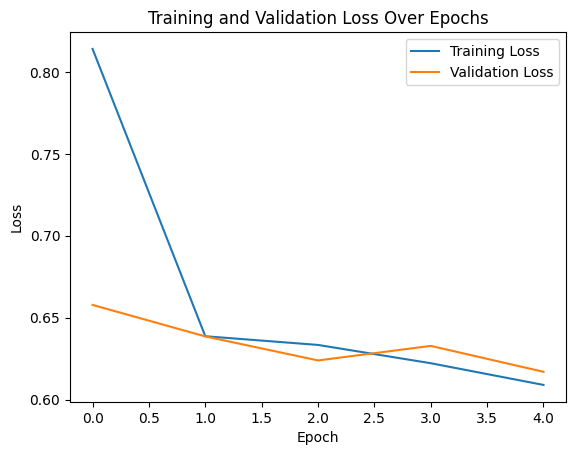


Starting Test and Visualize Samples...💡

=== [Test Set Evaluation] ===
📊 Metriche globali:
  - mIoU     : 0.8687
  - Precision: 0.9749
  - Recall   : 0.9004
  - F1 Score : 0.9362

🔢 Conteggi:
  - TP: 5332 | FP: 137 | FN: 590

📈 IoU stats:
  - min   : 0.50
  - max   : 0.99
  - median: 0.89

=== [mAP Evaluation] ===
  - map: 0.6544
  - map_50: 0.8894
  - map_75: 0.7837
  - map_small: -1.0000
  - map_medium: 0.6544
  - map_large: 0.2792
  - mar_1: 0.0169
  - mar_10: 0.1671
  - mar_100: 0.7058
  - mar_small: -1.0000
  - mar_medium: 0.7061
  - mar_large: 0.2750
  - map_per_class: -1.0000
  - mar_100_per_class: -1.0000
  - classes: 1


Extracting Predicted ROI Features: 100%|██████████| 120/120 [00:51<00:00,  2.34it/s]
/tmp/ipython-input-14-2614316370.py:104: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  feature_tensor = torch.tensor(all_features)


✅ ROI features predette salvate in: roi_features_val.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

⬇️ File pronto per il download!
📁 Risultati salvati in: results/results_20250708_141603.json


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

⬇️ File pronto per il download!

=== Sample 1 ===
GT: 67, Predetti (score ≥ 0.3): 64
mIoU: 0.8503
TP: 62, FP: 2, FN: 5
Precision: 0.9688, Recall: 0.9254, F1: 0.9466


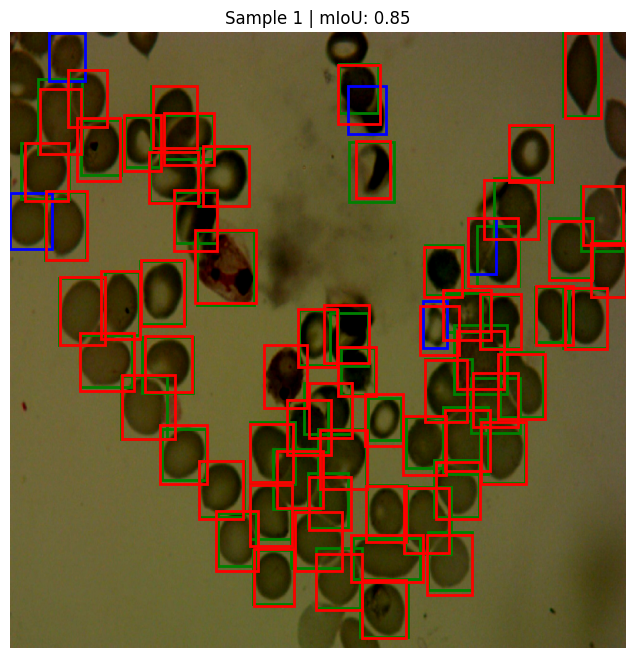


=== Sample 2 ===
GT: 56, Predetti (score ≥ 0.3): 56
mIoU: 0.9023
TP: 54, FP: 2, FN: 2
Precision: 0.9643, Recall: 0.9643, F1: 0.9643


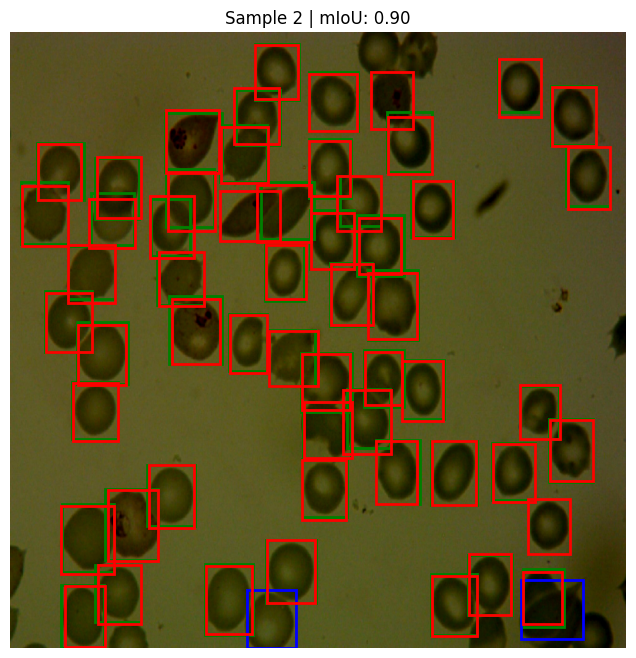


=== Sample 3 ===
GT: 79, Predetti (score ≥ 0.3): 65
mIoU: 0.8412
TP: 63, FP: 2, FN: 16
Precision: 0.9692, Recall: 0.7975, F1: 0.8750


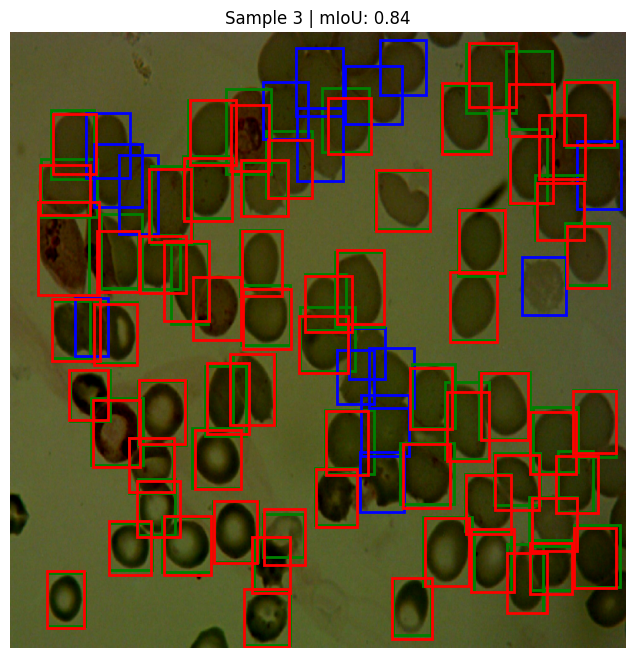

In [ ]:
# ==== MAIN ====
if __name__ == "__main__":
    print("Starting training... ⏳")

    print({
         "model": Config.MODEL,
         "lr": Config.LEARNING_RATE,
         "batch_size": Config.BATCH_SIZE,
        "num_epochs": Config.NUM_EPOCHS,
        "weight_decay": Config.WEIGHT_DECAY,
        "patience": Config.PATIENCE,
         "optimizer": Config.Optim,
         "scheduler": Config.Scheduler,
        "img_size": Config.IMG_SIZE
    })
    history = train_model()

    plt.plot(history['train_loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.legend()
    plt.show()


    print("\nStarting Test and Visualize Samples...💡")
    test_dataset = MalariaDataset(Config.TEST_JSON, Config.IMG_DIR,
                                  transform=get_transforms(train=False), resize=True)
    visualize_results(Config.MODEL_SAVE_PATH, test_dataset, 3, 0.3)

---

In [ ]:
visualize_results(Config.MODEL_SAVE_PATH, test_dataset, 3, 0.3)


=== [Test Set Evaluation] ===
📊 Metriche globali:
  - mIoU     : 0.8687
  - Precision: 0.9749
  - Recall   : 0.9004
  - F1 Score : 0.9362

🔢 Conteggi:
  - TP: 5332 | FP: 137 | FN: 590

📈 IoU stats:
  - min   : 0.50
  - max   : 0.99
  - median: 0.89


KeyboardInterrupt: 